+ **NOTE**: This notebook is trained on Google Colaboratory

## Importing Libraries

In [0]:
import csv
import random
import numpy as np
import tensorflow as tf

## Loading Dataset

In [37]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-06-01 07:20:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  78.2MB/s    in 2.9s    

2020-06-01 07:20:50 (78.2 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



## Building Corpus

+ corpus => [sentence, label]

In [38]:
corpus = []
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])

        if row[0]=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        
        corpus.append(list_item)

print('No. of corpus:', len(corpus), end='\n\n')

print('Examples-')
print('First corpus:', corpus[0])
print('Second corpus:', corpus[1])

No. of corpus: 1600000

Examples-
First corpus: ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 0]
Second corpus: ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


## Shuffling the data

In [0]:
random.shuffle(corpus)

## Splitting into sentences and labels

In [0]:
sentences, labels = [], []
for i in corpus:
    sentences.append(i[0])
    labels.append(i[1])

## Setting some hyper-parameters

In [0]:
vocab_size = 200000
embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = len(corpus)  # 1600000
test_portion = .1

## Loading Tokenizer & fitting it on our sentences

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(sentences)

## Mappings

In [43]:
word_index = tokenizer.word_index
print('No. of words:', len(word_index))

No. of words: 690960


## Converting sentences into sequences & padding them

In [44]:
sequences = tokenizer.texts_to_sequences(sentences)
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print('Examples-')
for i in range(3):
    print(padded_seq[i])

Examples-
[   23   149  1170   541     7   220   101    10     3 26365  5038     0
     0     0     0     0]
[  86  170 4061   10    3 5964    1   16  100  786   32   30   32   30
  217    1]
[  75   50   11    4  598  348   13    3 2500    6  269 6123    3   51
 1390    0]


In [45]:
# taking top vocab_size into conideration
s = 0
for i in range(training_size):
    s = max(s, max(padded_seq[i]))
s

199999

## Splitting into training & test sets

In [0]:
# as our model expects tensors/numpy-array instead of lists
labels_array = np.array(labels)

In [0]:
split = int(test_portion * training_size)

test_sequences = padded_seq[0:split]
training_sequences = padded_seq[split:training_size]

test_labels = labels_array[0:split]
training_labels = labels_array[split:training_size]

## Loading Glove Model

+ [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
+ GloVe is an unsupervised learning algorithm for obtaining vector representations for words.
+ Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [47]:
# Note this is the 100 dimension version of GloVe from Stanford

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-06-01 07:22:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  89.2MB/s    in 3.7s    

2020-06-01 07:22:22 (89.2 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



## Mappings of GloVe

In [0]:
embeddings_index = {}
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

In [49]:
embeddings = list(embeddings_index.items())

print('No. of distinct words embeddings:', len(embeddings_index))
print('Length of a embedding:', len(embeddings[0][1]))

print('\nExample:', embeddings[0][0])
print(embeddings[0][1])

No. of distinct words embeddings: 400000
Length of a embedding: 100

Example: the
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.0170

## Creating Embedding Matrix

In [0]:
# we are adding 1 to vocab_size for oov_token as we don't included in our Tokenizer
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

dct = list(word_index.items())[:vocab_size]
for word, i in dct:
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [55]:
embeddings_matrix.shape

(200001, 100)

## Creating Model

In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=(vocab_size+1), output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           20000100  
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 20,065,253
Trainable params: 65,153
Non-trainable params: 20,000,100
_____________________________________

## Compiling the model

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

## Training the model

In [69]:
num_epochs = 5
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

Epoch 1/5
45000/45000 [==============================] - 330s 7ms/step - loss: 0.5185 - acc: 0.7383 - val_loss: 0.4834 - val_acc: 0.7632
Epoch 2/5
45000/45000 [==============================] - 329s 7ms/step - loss: 0.4931 - acc: 0.7568 - val_loss: 0.4795 - val_acc: 0.7659
Epoch 3/5
45000/45000 [==============================] - 333s 7ms/step - loss: 0.4869 - acc: 0.7605 - val_loss: 0.4722 - val_acc: 0.7713
Epoch 4/5
45000/45000 [==============================] - 328s 7ms/step - loss: 0.4837 - acc: 0.7628 - val_loss: 0.4730 - val_acc: 0.7711
Epoch 5/5
45000/45000 [==============================] - 321s 7ms/step - loss: 0.4813 - acc: 0.7645 - val_loss: 0.4692 - val_acc: 0.7724


## Visualizing model accuracy

<Figure size 432x288 with 0 Axes>

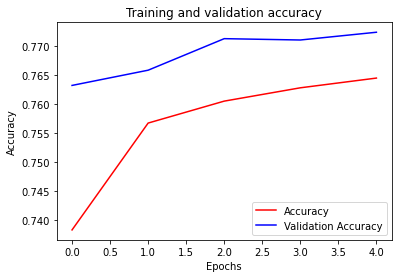

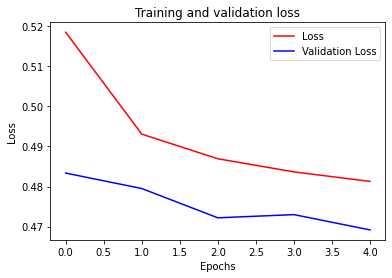

<Figure size 432x288 with 0 Axes>

In [71]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!